**You can find this notebook on Kaggle [here](https://www.kaggle.com/code/forbo7/how-to-convert-audio-to-spectrogram-images).**

> This notebook follows the [fastai style conventions](https://docs.fast.ai/dev/style.html#style-guide).

![](../images/10_how_to_convert_audio_to_spectrogram_images/thumbnail.jpg){fig-alt="A generated image of a colorful East African bird."}

In this to-the-point notebook, I go over how one can create images of spectrograms from audio files using the PyTorch torchaudio module.

The notebook also goes over how I created the spectrogram images for the BirdCLEF 2023 competition, and how one can create and push a dataset right on Kaggle (useful if your local machine doesn't have enough storage).

You can view the dataset that was generated from this notebook [here](https://www.kaggle.com/datasets/forbo7/spectrograms-birdclef-2023).

## Setup

In [1]:
try: from fastkaggle import *
except ModuleNotFoundError:
    ! pip install -Uqq fastkaggle
    from fastkaggle import *

iskaggle

'Batch'

In [2]:
comp = 'birdclef-2023'
d_path = setup_comp(comp, install='nbdev')

In [3]:
from fastai.imports import *
from fastai.vision.all import *

## Data

### Paths

Let's see all the files and directories we have.

In [4]:
d_path.ls()

(#5) [Path('../input/birdclef-2023/sample_submission.csv'),Path('../input/birdclef-2023/train_audio'),Path('../input/birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('../input/birdclef-2023/train_metadata.csv'),Path('../input/birdclef-2023/test_soundscapes')]

Let's get the path to the audio files.

In [5]:
aud_files = d_path/'train_audio'

And create a directory to store the spectrogram images.

In [6]:
mkdir('/kaggle/train_images', exist_ok=True); Path('/kaggle/train_images').exists()

True

## Single Image

It's always a good idea to try things out on a smaller scale; so let's begin by converting only a single audio file.

Let's get the first audio file.

In [7]:
aud_files.ls()

(#264) [Path('../input/birdclef-2023/train_audio/yetgre1'),Path('../input/birdclef-2023/train_audio/moccha1'),Path('../input/birdclef-2023/train_audio/rostur1'),Path('../input/birdclef-2023/train_audio/walsta1'),Path('../input/birdclef-2023/train_audio/ratcis1'),Path('../input/birdclef-2023/train_audio/norfis1'),Path('../input/birdclef-2023/train_audio/macshr1'),Path('../input/birdclef-2023/train_audio/brrwhe3'),Path('../input/birdclef-2023/train_audio/crefra2'),Path('../input/birdclef-2023/train_audio/pabspa1')...]

In [8]:
aud_files.ls()[0].ls()

(#27) [Path('../input/birdclef-2023/train_audio/yetgre1/XC247367.ogg'),Path('../input/birdclef-2023/train_audio/yetgre1/XC574558.ogg'),Path('../input/birdclef-2023/train_audio/yetgre1/XC403259.ogg'),Path('../input/birdclef-2023/train_audio/yetgre1/XC498854.ogg'),Path('../input/birdclef-2023/train_audio/yetgre1/XC289493.ogg'),Path('../input/birdclef-2023/train_audio/yetgre1/XC716763.ogg'),Path('../input/birdclef-2023/train_audio/yetgre1/XC498853.ogg'),Path('../input/birdclef-2023/train_audio/yetgre1/XC338717.ogg'),Path('../input/birdclef-2023/train_audio/yetgre1/XC349660.ogg'),Path('../input/birdclef-2023/train_audio/yetgre1/XC403543.ogg')...]

In [9]:
aud = aud_files.ls()[0].ls()[0]; aud

Path('../input/birdclef-2023/train_audio/yetgre1/XC247367.ogg')

Now it's time to load it in. What we get in return is the waveform and the sample rate.

In [10]:
import torchaudio
wvfrm, sr = torchaudio.load(aud); wvfrm

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0518e-05, 0.0000e+00,
         0.0000e+00]])

---

#### BirdCLEF 2023 — Clipping the Audio Files

This competition requires predictions to be submitted of all 5 second intervals in each audio clip. This means the audio files need to be clipped.

Below is an easy way this can be done. We clip the first 5 seconds of the audio file.

In [11]:
start_sec = 0
end_sec = 5
wvfrm = wvfrm[:, start_sec*sr:end_sec*sr]
wvfrm.shape[1] / sr

5.0

Sample rate is simply the number of frames recorded per second. The waveform that torchaudio returns is a tensor of frames. Therefore, we can easily select the desired range of frames by multiplying the sample rate with the desired start and end seconds.

---

Now let's create the spectrogram.

In [12]:
import torchaudio.transforms as T
spec = T.Spectrogram()(wvfrm); spec

tensor([[[4.3970e-08, 8.2461e-09, 4.7306e-11,  ..., 7.8266e-08,
          1.7642e-08, 1.5016e-03],
         [6.3310e-09, 6.5514e-10, 1.6958e-08,  ..., 4.3492e-09,
          3.6019e-08, 1.5231e-03],
         [1.1548e-08, 1.7308e-08, 6.5956e-08,  ..., 2.9340e-06,
          1.2277e-06, 1.4124e-03],
         ...,
         [2.4446e-07, 6.1277e-09, 1.4932e-09,  ..., 1.4665e-08,
          1.0110e-08, 1.8980e-05],
         [3.1582e-07, 1.4777e-09, 1.2275e-08,  ..., 1.3213e-08,
          1.9035e-09, 2.0009e-05],
         [3.1673e-07, 1.1897e-10, 2.7457e-09,  ..., 1.0001e-08,
          6.0452e-14, 1.9979e-05]]])

Let's scale it logarithmically. This allows for better viewing.

In [13]:
spec = T.AmplitudeToDB()(spec); spec

tensor([[[ -73.5684,  -80.8375, -100.0000,  ...,  -71.0643,  -77.5346,
           -28.2346],
         [ -81.9853,  -91.8367,  -77.7063,  ...,  -83.6159,  -74.4347,
           -28.1726],
         [ -79.3751,  -77.6177,  -71.8074,  ...,  -55.3254,  -59.1092,
           -28.5005],
         ...,
         [ -66.1180,  -82.1270,  -88.2588,  ...,  -78.3373,  -79.9524,
           -47.2170],
         [ -65.0056,  -88.3043,  -79.1097,  ...,  -78.7899,  -87.2045,
           -46.9877],
         [ -64.9931,  -99.2458,  -85.6135,  ...,  -79.9997, -100.0000,
           -46.9943]]])

The PyTorch tensor needs to be converted into a NumPy array so it can then further be converted to an image. I'm using the `squeeze` method to remove the uneeded axis of length 1, as seen below.

In [14]:
spec.shape

torch.Size([1, 201, 801])

In [15]:
spec = spec.squeeze().numpy(); spec

array([[ -73.56842 ,  -80.83749 , -100.      , ...,  -71.064285,
         -77.53463 ,  -28.234562],
       [ -81.98525 ,  -91.83666 ,  -77.706314, ...,  -83.615875,
         -74.43467 ,  -28.172626],
       [ -79.37505 ,  -77.61765 ,  -71.80743 , ...,  -55.32541 ,
         -59.109177,  -28.500452],
       ...,
       [ -66.118   ,  -82.127014,  -88.25883 , ...,  -78.33732 ,
         -79.95244 ,  -47.21705 ],
       [ -65.00563 ,  -88.30426 ,  -79.10974 , ...,  -78.78989 ,
         -87.20445 ,  -46.987743],
       [ -64.99306 ,  -99.24575 ,  -85.61355 , ...,  -79.99969 ,
        -100.      ,  -46.994343]], dtype=float32)

In [16]:
spec.shape

(201, 801)

The array now needs to be normalized so it contains integers between 0 and 255: the values needed for images.

In [17]:
spec = (spec - spec.min()) / (spec.max() - spec.min()) * 255; spec

array([[ 53.000538 ,  38.424625 ,   0.       , ...,  58.021824 ,
         45.047504 , 143.90388  ],
       [ 36.123127 ,  16.369104 ,  44.703243 , ...,  32.853405 ,
         51.263535 , 144.02808  ],
       [ 41.35709  ,  44.881027 ,  56.53168  , ...,  89.581375 ,
         81.99417  , 143.37071  ],
       ...,
       [ 67.94011  ,  35.838867 ,  23.543371 , ...,  43.437954 ,
         40.199318 , 105.84024  ],
       [ 70.17062  ,  23.452267 ,  41.889095 , ...,  42.530468 ,
         25.6576   , 106.30005  ],
       [ 70.19584  ,   1.5124193,  28.847677 , ...,  40.104576 ,
          0.       , 106.28681  ]], dtype=float32)

In [18]:
spec = spec.astype('uint8'); spec

array([[ 53,  38,   0, ...,  58,  45, 143],
       [ 36,  16,  44, ...,  32,  51, 144],
       [ 41,  44,  56, ...,  89,  81, 143],
       ...,
       [ 67,  35,  23, ...,  43,  40, 105],
       [ 70,  23,  41, ...,  42,  25, 106],
       [ 70,   1,  28, ...,  40,   0, 106]], dtype=uint8)

Now we can finally convert the array to an image!

(201, 801)


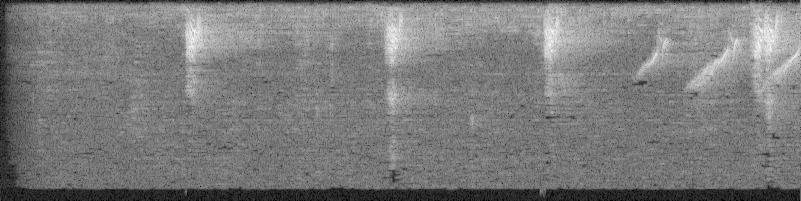

In [19]:
img = Image.fromarray(spec)
print(img.shape)
img

Cool, hey? We've just visualized audio!

---

#### BirdCLEF 2023 — Resizing the Images

To allow the images to easily be used by various models, I resized the spectrograms to be 512 by 512 pixels as shown below.

(512, 512)


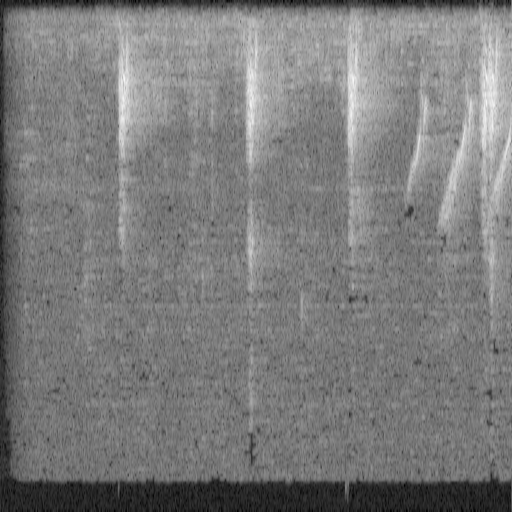

In [20]:
img_size = (512, 512)
img = img.resize(img_size)
print(img.shape); img

---

To save the image, we can simply use the `save` method.

In [21]:
img.save('img.png')

## All the Images

Now that we have verified that our algorithm works fine, we can extend it to convert all audio files.

In [22]:
def create_imgs(duration, f):
    for step in range(0, duration, 5):
        wvfrm, sr = torchaudio.load(f)
        wvfrm = cut_wvfrm(wvfrm, sr, step)
        spec = create_spec(wvfrm)
        img = spec2img(spec)
        end_sec = step + 5
        img.save(f'/kaggle/train_images/{bird.stem}/{f.stem}_{end_sec}.png')

def cut_wvfrm(wvfrm, sr, step):
    start_sec, end_sec = step, step + 5
    return wvfrm[:, start_sec * sr: end_sec * sr]
            
def create_spec(wvfrm):
    spec = T.Spectrogram()(wvfrm)
    return T.AmplitudeToDB()(spec)
        
def spec2img(spec, img_size=(512, 512)):
    spec = np.real(spec.squeeze().numpy())
    spec = ((spec - spec.min()) / (spec.max() - spec.min()) * 255).astype('uint8')
    return Image.fromarray(spec).resize(img_size)

In [23]:
if not iskaggle:
    for bird in aud_files.ls().sorted():
        mkdir(f'/kaggle/train_images/{bird.stem}', exist_ok=True)
        for f in bird.ls().sorted():
            info = torchaudio.info(f)
            duration = info.num_frames / info.sample_rate
            if duration >= 5:
                create_imgs(round(duration/5)*5, f)
            else: continue

> **Note:** Ignore the `if not iskaggle` statement when replicating. I added it since I edited this notebook and needed to save changes without reproducing the entire dataset.

In the first `for` loop below, we loop through all the bird folders. For each folder, a folder with the same name is created in the directory where we want to store the images.

In the second `for` loop, we loop through all audio files within the folder and then convert them to spectrogram images through the `create_images` function I defined.

---

#### BirdCLEF 2023 — Clipping the Audio Files

Some audio files in the training set are of different durations. Therefore, we obtain the duration of the audio file so it can correctly be clipped into 5 second intervals.

```python
info = torchaudio.info(f)
duration = info.num_frames / info.sample_rate
if duration >= 5:
    create_images(round(duration/5)*5, f)
else: continue
```

Again, since sample rate is the number of frames recorded per second, we can divide the total number of frames by the sample rate to obtain the duration in seconds of a clip.

`duration = info.num_frames / info.sample_rate`

Then we round the duration to the nearest 5 for easy clipping.

`round(duration/5)*5`

---

The images now created! The rest of this notebook covers how one can generate a dataset in a Kaggle Notebook and push it directly to Kaggle within it.

## API Setup

We need to configure the user keys so we can push to the correct account.

To do this, first obtain your Kaggle API key. Then, while in the notebook editor, click Add-ons -> Secrets -> Add a New Secret...

<img src="https://sat02pap002files.storage.live.com/y4mY_6mu6XXxmpkR_MwTxHxfEGRV9QOqlxkCF8i6T90WkRadthJc9yeOxUG3k21bT-QQ4CxJcP1W-MHuAhX_tKvf-gcZqUvkLONiKPeumqZCTezKhwXJXs0OFuTDBnedbcViCOeeIkzjVjYJiBc3J7ib0AqG5v247vovXQP1JYv-8RmfWMFytuyCgwvLNt_5MSP?width=2880&height=1800&cropmode=none" width="75%" height="100%" />

<img src="https://sat02pap002files.storage.live.com/y4mBCKZg2xbmSClGOAWdxf6vXcrgLKV0TNe-SuLaS37nzKAuHpzMZsXL0lEAuauWYrrKnZVx2qGStH3ZjVn-E0xARzTUW7UN9Em3gx_X3qivCHIX_85Z0aQc0xQYrl2dJPvyPOHwuCm0ML5188bFuemgoQik3jn_TVih1YKxYw9Z79fDahzG8wD9Yu-zbizRsVS?width=1024&height=640&cropmode=none" width="75%" height="100%" />

<img src="https://sat02pap002files.storage.live.com/y4mgCDqODGoakfC1zbSK1tEGy1gcUPMpzzw5DEFHJnQPZIWZpWn2WKLT48EGRky-kXSmBYt-BYSgVxO7jMVT321_gqOYjX0daxumANws9LpNOvwdG3ce9nKJFT8ZkSEjtb5Q93leY75dKLk2CumNpmRGi4WoZr5jsTPPEV42yTlNPURAMrSsl09XeKqGaBjJO0u?width=2880&height=1800&cropmode=none" width="75%" height="100%" />

...input your key and give it a name...

<img src="https://sat02pap002files.storage.live.com/y4mz3E2oKRG9H8n6cSwx-uk8ZAuIB8WSExJX92_w8ZoqYkX4f72QXKM2AFjjn7n_UaS30btHk6ueSi9VTRD_us_pUp3CSo3MkBM0mRBZqeqYDrSY4GRGamkrYnNKtxfZ-PQKJEvjOr8r8N97cftsJ3-9fEUcO3jv8kVGniKNPHWx_aVpIElx4_qgVq-aRt30PSD?width=2880&height=1800&cropmode=none" width="75%" height="100%" />

...and click save. Then click the checkbox next to the secret to activate it for your notebook.

<img src="https://sat02pap002files.storage.live.com/y4m3RfkLD7cbynZIPmI7X17qmHTxar-hX5p-w5G70Z3YiRiIPzkzo3Z9h1Z4eWecrmmU88yl-HXUSRU7xUQ0LN2C-_wn_qmKDJFJyXSjNfhV7XjKpGbyhxXU9JCaTOxZhRwHGl4ghkykkhpMBTpoG-dxe7YlhPI40DQJT2dvCcuv1KZQkYkcOHIqiUI8SvwhL4Q?width=2880&height=1800&cropmode=none" width="75%" height="100%" />

Repeat for your Kaggle username.

Now we can set the keys for the notebook as shown below (input the name of your key into `get_secret`).

In [24]:
import os
from kaggle_secrets import UserSecretsClient

In [25]:
secrets = UserSecretsClient()
os.environ['KAGGLE_USERNAME'] = secrets.get_secret('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = secrets.get_secret('KAGGLE_KEY')

## Push Dataset

The [fastkaggle](fastkaggle) library offers a convenient way to easily create and push a dataset to Kaggle.

In [26]:
doc(mk_dataset)

> **Note:** Ignore the `if not iskaggle` statement when replicating. I added it since I edited this notebook and needed to save changes without reproducing the entire dataset.

In [27]:
if not iskaggle:
    mk_dataset('/kaggle/train_images', 'spectrograms-birdclef-2023', force=True, upload=True)

And we can verify our dataset has been created by having a look at the generated metadata file.

In [28]:
if not iskaggle:
    ! cat /kaggle/train_images/dataset-metadata.json

From here, we can go directly to the dataset page on Kaggle and fill out the rest of the details.

## And there you have it!

In summary, you saw how to:
* Generate spectrogram images from audio files using torchaudio and fastai
* How to cut audio tracks
* And how to create and push a dataset directly on Kaggle

You can view the dataset that was generated from this notebook [here](https://www.kaggle.com/datasets/forbo7/spectrograms-birdclef-2023).

If you have any comments, questions, suggestions, feedback, criticisms, or corrections, please do post them down in the comment section below!